# HM1: Text Classification

### Name: [Yupeng Cao]
### ID: [10454637]

---
# Data Preparation

##  1.1 Preprocess data and Construct examples


In [1]:
import re
import numpy as np
import scipy
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
file_1 = 'data/28054-0.txt' #Define File Path
file_2 = 'data/pg31100.txt'
file_3 = 'data/pg1661.txt'

#Define a function to process raw data
#Inputs:
#       filepath: the location where you put data.
def txt2paragraph(filepath):
    
    url_reg  = r'[a-z]*[:.]+\S+' #Regular Expression for remove url
    punctuation = '.!,;:?""\'''*#@“'#Regular Expression for remove symbol
    
    #Load file
    with open(filepath, "r", encoding="UTF-8") as file:
        lines = file.read()
    new = lines.split("\n\n") #Split file into paragraphy
    
    #Preprocess for each paragraphy
    for para in range(len(new)):
        new[para] = new[para].lower().replace('\n', '') #remove \n
        new[para] = re.sub(url_reg, '', new[para]) #remove url
        new[para] = new[para].strip() #remove blank space
        new[para] = re.sub(r'\d+', '', new[para]) #remove digit
        new[para] = re.sub(r'[{}]+'.format(punctuation),'',new[para]) #remove puncutation and symbol

    #Double check 
    while '' in new:
        new.remove('')
    #Return the results
    return new

#Remove the irrevelant information at the begin and end of the E-Book.
data_1 = txt2paragraph(file_1)[19:5959]
data_2 = txt2paragraph(file_2)[29:11047]
data_3 = txt2paragraph(file_3)[14:1986]

In [3]:
#
#Construct the dataset by using three sub-data from last step:
#    1. Construct the dataframe for each part by using Pandas.DataFrame
#    2. Connect the each part to form the whole dataset.


dataset_part1 = pd.DataFrame()
dataset_part1['text'] = data_1
#dataset_part1['label'] = 0
dataset_part1['label'] = 'Fyodor Dostoyevsky'

dataset_part2 = pd.DataFrame()
dataset_part2['text'] = data_2
#dataset_part2['label'] = 1
dataset_part2['label'] = 'Jane Auste'

dataset_part3 = pd.DataFrame()
dataset_part3['text'] = data_3
#dataset_part3['label'] = 2
dataset_part3['label'] = 'Arthur Conan Doyle'

text_data = [dataset_part1, dataset_part2,dataset_part3]
dataset = pd.concat(text_data, axis = 0, ignore_index=True)
dataset = shuffle(dataset) #We shuffle the dataset 

#print(dataset) # You can view the final DataFrame 
print(str(len(data_1)) + ' text data belongs to Fyodor Dostoyevsky')
print(str(len(data_2)) + ' text data belongs to Jane Auste')
print(str(len(data_3)) + ' text data belongs to Arthur Conan Doyle')

5940 text data belongs to Fyodor Dostoyevsky
11018 text data belongs to Jane Auste
1972 text data belongs to Arthur Conan Doyle


## 1.2 Data split

In [4]:
from sklearn import model_selection, preprocessing

In [5]:
# Encoding the label
encoder = preprocessing.LabelEncoder()
dataset['encode_label'] = encoder.fit_transform(dataset['label'].values)

#Valdation part: 20%
#Because we shuffle the dataset at the last step, therefore, we set random_state is 1.
train_x, val_x, train_y, val_y = model_selection.train_test_split(dataset['text'].values, dataset['encode_label'].values,
                                                                  test_size=0.2, random_state=1)
train_y = train_y.reshape(-1,1)
val_y = val_y.reshape(-1,1)


## 1.3 Feature Extraction: TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.corpus

In [7]:
# Set the stop words
# min_df = 50:
#      If the frequency of the word lower than 50 times, it wll be ignored
stop_w = nltk.corpus.stopwords.words('english') 
tfidf_vect = TfidfVectorizer(stop_words = stop_w, min_df=50)

#Calculate TF-IDF
tfidf_vect.fit(dataset['text'])
xtrain = tfidf_vect.transform(train_x)
xval = tfidf_vect.transform(val_x)
xtrain = xtrain.toarray()
xval = xval.toarray()

---
# Logistic Regression

$$ J = -\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log(\frac{exp f_{k}}{\sum_{K}^{c=1}expf_{c}}) + \lambda \sum_{j=1}^{d}w_{kj}^2 $$ <br>

**The gradient of J with respect to wk is:**<br>
**Let $Z = \omega _{k}^Tx$**. Then, applying chain rule to **J**: <br>
$$\frac{\partial J}{\partial \omega } = \frac{\partial Z}{\partial \omega } \frac{\partial J}{\partial Z } + 2\lambda \sum \omega _{k}$$<br>
$$\frac{\partial J}{\partial \omega } = x^T(\frac{exp(\omega_{i})}{\sum_{k} exp(\omega _{k}) }) + 2\lambda \sum_{k}\omega _{k}$$

In [8]:
# Define One-Hot encoding function and softmax function
# Two function will be used in mini-batch SGD and SGD

#Input:
#      y: label
def OneHot(y, num_class=3):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label.astype('int')] = 1
    return results

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)  

## 2.1 Mini-Batch SGD

In [9]:
#Define the objective function and gradient function
# Inputs:
#     x: n-by-d matrix, n is batch size at here
#     w: d-by-3 matrix
#     y: n-by-3 matrix, n is batch size at here
def mb_sgd_objective_gradient(w,x,y,lam):
    
    n,d = x.shape
    y_mat = OneHot(y)
    xw = np.dot(x,w)
    exp_xw = softmax(xw)
    
    obj = -np.mean(np.sum(y_mat * np.log(exp_xw),axis=1)) + lam*np.sum(w*w)
    
    grad = -(1/n) * np.dot(x.T,(y_mat - exp_xw)) + lam * w
    
    return obj, grad

In [10]:
#Implement the mini-batch SGD
#Input:
#      x: whole dataset
#      y: whole labels
#      lam: the regularization parameter
#      batch_size: 4, 8, 16, 32, 64, 128, 256...
#      stepsize: learning rate
#      max_epochs: 100
#      w: we initialize w metrix in function.
def mb_gradient_descent(x,y,lam,batch_size,stepsize,max_epochs,w=None):

    n,d = x.shape
    num_batch = int(np.ceil(n/batch_size))
    obj_vals = np.zeros(max_epochs)
    
    #initialize w metrix
    # w: d-by-3
    if w is None:
        w = np.zeros((d,3))

    for epoch in range(max_epochs):
        rand_index = np.random.permutation(n)
        x_rand = x[rand_index,:]
        y_rand =y[rand_index]
        obj_val = 0
        
        for i in range(1,num_batch+1):
            mini_x = x_rand[(i-1)*batch_size:i*batch_size, :]
            mini_y = y_rand[(i-1)*batch_size:i*batch_size]
      
            obj, g = mb_sgd_objective_gradient(w,mini_x,mini_y,lam)
            obj_val += obj
            w -= stepsize * g
    
        obj_val /= num_batch
        obj_vals[epoch] = obj_val
        print('Objective value at ' + str(epoch) + ' is ' + str(obj_val))
    
    return w, obj_vals

In [12]:
w, obj_vals = mb_gradient_descent(xtrain, train_y, 1E-6, 128, stepsize = 0.01, max_epochs = 100, w=None)

Objective value at 0 is 4.841205388760497
Objective value at 1 is 4.839036827618762
Objective value at 2 is 4.836956097281766
Objective value at 3 is 4.834877449700911
Objective value at 4 is 4.832813646356651
Objective value at 5 is 4.830810268514768
Objective value at 6 is 4.8288743407883965
Objective value at 7 is 4.826965364572173
Objective value at 8 is 4.825058529942545
Objective value at 9 is 4.823269236978596
Objective value at 10 is 4.821434146703816
Objective value at 11 is 4.819587591165848
Objective value at 12 is 4.817854764025717
Objective value at 13 is 4.81606054663267
Objective value at 14 is 4.814394410266627
Objective value at 15 is 4.812734843403792
Objective value at 16 is 4.81117635379941
Objective value at 17 is 4.809533530783282
Objective value at 18 is 4.807950144622446
Objective value at 19 is 4.806606748812173
Objective value at 20 is 4.804982128173232
Objective value at 21 is 4.803620129675079
Objective value at 22 is 4.8022680485548745
Objective value at 23

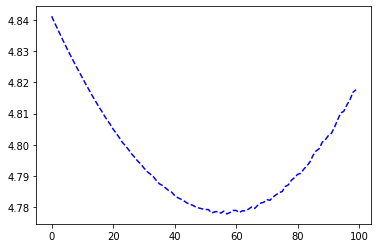

In [19]:
fig_1 = plt.figure(figsize=(6, 4))
x_range = range(len(obj_vals))
plt.plot(x_range, obj_vals, '--b', label = 'Training loss')

## 2.2 SGD

In [13]:
def sgd_objective_gradient(w,x,y,lam):
    
    y_mat = OneHot(y)
    xw = np.dot(x,w)
    exp_xw = softmax(xw)
    
    obj = -np.mean(np.sum(y_mat * np.log(exp_xw),axis=1)) + lam*np.sum(w*w)
    
    grad = -np.dot(x.T,(y_mat - exp_xw)) + lam * w
    
    return obj, grad

In [16]:
def sgd(x,y,lam,stepsize,max_epochs,w=None):
    n,d = x.shape
    obj_vals = np.zeros(max_epochs)
    
    if w is None:
        w = np.zeros((d,3))

    for epoch in range(max_epochs):
        rand_index = np.random.permutation(n)
        x_rand = x[rand_index,:]
        y_rand = y[rand_index]
        obj_val = 0
        
        for i in range(n):
            xi = x_rand[i, :].reshape(1, -1)
            yi = y_rand[i]
      
            obj, g = sgd_objective_gradient(w,xi,yi,lam)
            obj_val += obj
            w -= stepsize * g
        stepsize *= 0.9
        obj_val /= n
        obj_vals[epoch] = obj_val
        print('Objective value at ' + str(epoch) + ' is ' + str(obj_val))
    
    return w, obj_vals

In [18]:
sgd(xtrain, train_y, 1E-6, stepsize = 0.001 ,max_epochs = 100, w=None)

Objective value at 0 is 1.997216024105853e-06
Objective value at 1 is 1.2981924469317569e-05
Objective value at 2 is 3.211567839215851e-05
Objective value at 3 is 5.681897069036438e-05
Objective value at 4 is 8.515164484057553e-05
Objective value at 5 is 0.00011556025864877883
Objective value at 6 is 0.0001469415765894066
Objective value at 7 is 0.00017840463445470146
Objective value at 8 is 0.00020936078354660833
Objective value at 9 is 0.00023924458513038615
Objective value at 10 is 0.0002678292141217612
Objective value at 11 is 0.00029509011720939835
Objective value at 12 is 0.00032061613905034055
Objective value at 13 is 0.0003445884248839607
Objective value at 14 is 0.00036682352842519835
Objective value at 15 is 0.00038747708748389985
Objective value at 16 is 0.0004066191603988936
Objective value at 17 is 0.00042414875924706865
Objective value at 18 is 0.00044022626054758134
Objective value at 19 is 0.00045497949057957967
Objective value at 20 is 0.0004685072936788654
Objective v

(array([[-0.17302712, -0.17171733, -0.0013098 ],
        [-0.12924281, -0.12924281,  0.        ],
        [-0.27087661, -0.2699903 , -0.00088631],
        ...,
        [-0.0963973 , -0.0902703 , -0.01048466],
        [-0.160566  , -0.11055724, -0.08384786],
        [-0.17175498,  0.        , -0.17175498]]),
 array([1.99721602e-06, 1.29819245e-05, 3.21156784e-05, 5.68189707e-05,
        8.51516448e-05, 1.15560259e-04, 1.46941577e-04, 1.78404634e-04,
        2.09360784e-04, 2.39244585e-04, 2.67829214e-04, 2.95090117e-04,
        3.20616139e-04, 3.44588425e-04, 3.66823528e-04, 3.87477087e-04,
        4.06619160e-04, 4.24148759e-04, 4.40226261e-04, 4.54979491e-04,
        4.68507294e-04, 4.80826913e-04, 4.92035429e-04, 5.02203597e-04,
        5.11527319e-04, 5.19932435e-04, 5.27554055e-04, 5.34487351e-04,
        5.40772154e-04, 5.46436500e-04, 5.51552282e-04, 5.56198255e-04,
        5.60396263e-04, 5.64167934e-04, 5.67594673e-04, 5.70675416e-04,
        5.73458836e-04, 5.75971518e-04, 5.7

Observing the loss value of SGD, it keeps a slight increase which means that optimization process doesn't convergence. Therefore, we didn't plot the loss curve for SGD. The error reason will be analyzed at the last part. 

## 2.3 MLP

**Pre-Requirement:**<br>
Tensorflow: pip install tensorflow<br>
Keras: pip install keras


In [8]:
from keras import models
from keras import layers
from keras.utils import to_categorical

Using TensorFlow backend.


In [34]:
train_labels = to_categorical(train_y)
test_labels = to_categorical(val_y)

#Build the model
#3-Layer MLP:
#    1. The size of input layer is same with the dimension of single data sample
#    2. Output: 256, 128, 3
#    3. Use softmax as the activation function at last layer
#    4. We choose rmsprop as optimizer

network = models.Sequential()
network.add(layers.Dense(256, activation = 'relu', input_shape = (xtrain.shape[1],)))
network.add(layers.Dense(128, activation = 'relu'))
network.add(layers.Dense(3, activation = 'softmax'))
network.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#models.summary() #You can use models.summary() to check the details.

In [35]:
#Training the model
history = network.fit(xtrain, train_labels, epochs = 30, batch_size = 64, validation_split = 0.2)

Train on 12115 samples, validate on 3029 samples
Epoch 1/30
12115/12115 [==============================] - 1s 119us/step - loss: 0.4718 - accuracy: 0.8024 - val_loss: 0.3388 - val_accuracy: 0.8646
Epoch 2/30
12115/12115 [==============================] - 1s 113us/step - loss: 0.2829 - accuracy: 0.8771 - val_loss: 0.3136 - val_accuracy: 0.8603
Epoch 3/30
12115/12115 [==============================] - 1s 113us/step - loss: 0.2442 - accuracy: 0.8946 - val_loss: 0.3085 - val_accuracy: 0.8613
Epoch 4/30
12115/12115 [==============================] - 1s 115us/step - loss: 0.2207 - accuracy: 0.9058 - val_loss: 0.3278 - val_accuracy: 0.8683
Epoch 5/30
12115/12115 [==============================] - 1s 113us/step - loss: 0.2013 - accuracy: 0.9135 - val_loss: 0.3411 - val_accuracy: 0.8699
Epoch 6/30
12115/12115 [==============================] - 1s 114us/step - loss: 0.1835 - accuracy: 0.9207 - val_loss: 0.3497 - val_accuracy: 0.8699
Epoch 7/30
12115/12115 [==============================] - 1s 11

In [36]:
test_loss, test_acc = network.evaluate(xval, test_labels)
print('test_acc', test_acc)
print('test_loss', test_loss)

3786/3786 [==============================] - 0s 26us/step
test_acc 0.8515583872795105
test_loss 1.0651354923553085


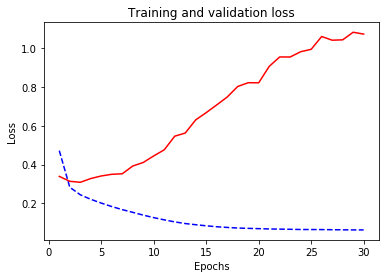

In [37]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, '--b', label = 'Training loss')
plt.plot(epochs, val_loss_values, '-r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Comparing the training loss and validation loss, we can found that the training process happened overfitting strating from 4 or 5 epochs. In addition, accuracy value also indicates overfitting. Because the train accuracy at 30 epoch is 0.97, but val accuracy is 0.85. This result means that trained model cannot generalize on novel dataset.<br>
Therefore, we suggest that epoch should be reduced at next training or we can choose the trained model from epoch 3 or epoch 4.

## 3. Cross Validation

**1.** For the MLP, we apply cross validation and show the validation loss value step by step. The curving of val_loss at part 2.3. Moreover, we test trained model on the test part of dataset and the test_acc is 0.85. Compare the results of many experiments, we found that 256-128-3 hidden layer structure can achieve the better results. However, we will do more experiments to test different the number of neurons in the hidden layer. <br>


**2.** For the mini-batch SGD and SGD, because we didn't get the reasonable loss value, we cannot choose the value of $\lambda$ at this time. We will analysis the failing reason at next part. However, we provides cross validation method at here:

In [21]:
# k-Folder Cross Validation

k = 5 

num_val_samples = len(xtrain) // k 

for i in range(k):
    
    val_data = xtrain[i * num_val_samples: (i + 1) * num_val_samples]
    val_label = train_y[i * num_val_samples: (i + 1) * num_val_samples]

We will use above code to choose $\lambda$ in the future experiment.

## 4. Analysis

**1.MLP:** MLP method got the best result. However, it happened overfitting at the early training stage. We can use a simple model or modify the different hyper-parameter to reduce the overfitting. <br>

**2.Mini-Batch SGD and SGD:** Although the algorithm can be executed, the results are undesirability. We provide some possible reasons that cause the unreasonable result:<br>
Firstly, the method of cleaning data maybe causes the problem.<br>
Secondly, feature extraction step maybe causes the problem. For example, the setting of stop_words and word frequency lead to the more information loss.<br>
Thirdly, the mathmatical part will lead to the error results, such as, the gradient equation includes the detailed error.


We will continue to try to solve the problem and bugs in this homework.

___